In [1]:
from autoencodeSVJ import utils, models, trainer
import glob
import os
import numpy as np
import keras
import keras.backend as K
import matplotlib.pyplot as plt

version_id = 'v5'
SEED = 42

Using TensorFlow backend.


In [3]:
# get h5 datasets
data_path = "data/background/*_data.h5"
signal_path = "data/signal/*_data.h5"

data, data_tags, data_jets = utils.load_all_data(data_path, "background")
signal, signal_tags, signal_jets = utils.load_all_data(signal_path, "signal")

split = 0.25

train, test = data.train_test_split(split, SEED)
utils.compare_tags([train, test, data, signal])

data_raw = data.cdrop("*Flavor")
signal_raw = signal.cdrop("*Flavor")
train_raw = train.cdrop("*Flavor")
test_raw = test.cdrop("*Flavor")

norm_args = {"norm_type": "StandardScaler"}
train_norm, test_norm = train_raw.norm(**norm_args), train_raw.norm(test_raw, **norm_args)
data_norm, signal_norm = train_raw.norm(data_raw, **norm_args), train_raw.norm(signal_raw, **norm_args)

background tags:

down jet: 18999, 18.4%
up jet: 38841, 37.6%
strange jet: 25377, 24.5%
charm jet: 9577, 9.3%
bottom jet: 3341, 3.2%
gluon jet: 7281, 7.0%

signal tags:

down jet: 1220, 2.5%
up jet: 1866, 3.8%
strange jet: 1550, 3.1%
charm jet: 3344, 6.8%
bottom jet: 38995, 78.8%
gluon jet: 2541, 5.1%

bottom:
	3.2% (2504) train
	3.2% (837) test
	3.2% (3341) background
	78.8% (38995) signal
up:
	37.4% (29023) train
	38.0% (9818) test
	37.6% (38841) background
	3.8% (1866) signal
down:
	18.4% (14251) train
	18.4% (4748) test
	18.4% (18999) background
	2.5% (1220) signal
strange:
	24.7% (19123) train
	24.2% (6254) test
	24.5% (25377) background
	3.1% (1550) signal
charm:
	9.2% (7151) train
	9.4% (2426) test
	9.3% (9577) background
	6.8% (3344) signal
gluon:
	7.1% (5510) train
	6.9% (1771) test
	7.0% (7281) background
	5.1% (2541) signal


In [22]:
bn = 2
name = "bn_{0}_{1}".format(bn, version_id)
repo_head = utils.get_repo_info()['head']
model_path = repo_head + "/autoencode/data/training_runs/"

ae_skeleton = models.base_autoencoder()
ae_skeleton.add(7)
ae_skeleton.add(100)
ae_skeleton.add(100)
ae_skeleton.add(bn, 'relu')
ae_skeleton.add(100)
ae_skeleton.add(100)
ae_skeleton.add(7, "linear")

autoencoder = ae_skeleton.build()
encoder, decoder = autoencoder.layers[1:]
instance = trainer.trainer(os.path.join(model_path, name))
autoencoder.summary()

h5_elt 'metric_names' :: creating group 'data' in file 'bn_2_v5.h5'
h5_elt 'metric_names' :: creating dataset 'data/metric_names' in file 'bn_2_v5.h5'
h5_elt 'training' :: creating group 'params' in file 'bn_2_v5.h5'
h5_elt 'training' :: creating dataset 'params/training' in file 'bn_2_v5.h5'
h5_elt 'config' :: creating dataset 'params/config' in file 'bn_2_v5.h5'
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
encoder (Model)              (None, 2)                 11102     
_________________________________________________________________
decoder (Model)              (None, 7)                 11107     
Total params: 22,209
Trainable params: 22,209
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras import backend as K

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

def r_square_np(true, pred):
    SS_res = np.sum(np.square(true - pred), axis=1)
    SS_tot = np.sum(np.square(true - np.mean(true, axis=0)), axis=1)
    return 1. - SS_res/SS_tot

def r_square_loss(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return SS_res/(SS_tot + K.epsilon())

# train, test = data.train_test_split(0.25)
# ntype="RobustScaler"
# train_norm, test_norm = data.norm(train, norm_type=ntype), data.norm(test, norm_type=ntype)

autoencoder = instance.train(
    x_train=train_norm.data,
    x_test=test_norm.data,
    y_train=train_norm.data,
    y_test=test_norm.data,
    optimizer="adam",
    loss='mae',
    epochs=2,
    model=autoencoder,
    metrics=[r_square, "mae", "mse"],
    force=True,
    batch_size=64,
    use_callbacks=True,
    learning_rate=0.001
)

train_shell :: using model passed as function argument
Train on 77562 samples, validate on 25854 samples
Epoch 101/102
1211/1211 [==============================] - 166s 137ms/step - loss: 0.1790 - r_square: 0.9200 - mean_absolute_error: 0.1790 - mean_squared_error: 0.0800 - val_loss: 0.1799 - val_r_square: 0.9177 - val_mean_absolute_error: 0.1799 - val_mean_squared_error: 0.0821
Epoch 102/102
 444/1211 [=========>....................] - ETA: 1:41 - loss: 0.1773 - r_square: 0.9209 - mean_absolute_error: 0.1773 - mean_squared_error: 0.0791

### 4. check results
it is easy to check things like loss, accuracy, etc. later on with this method - all data is saved to an h5 file unique to that training name.

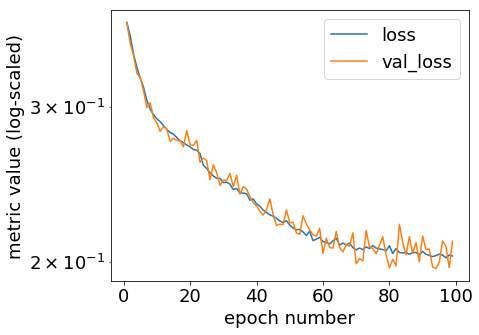

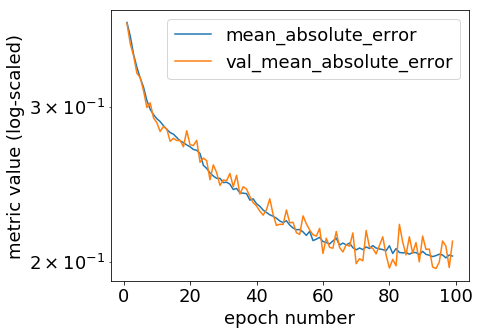

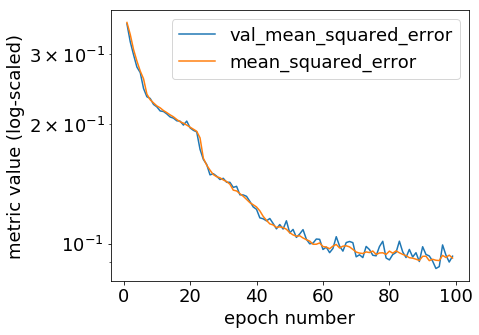

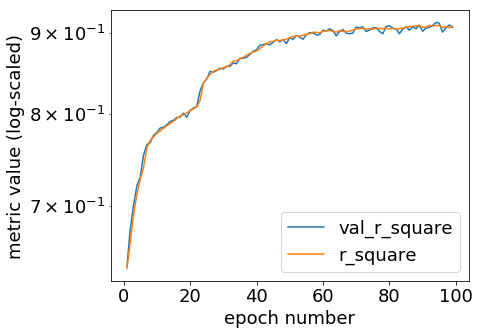

In [29]:
instance.plot_metrics(fnmatch_criteria="*loss*", yscale="log")
instance.plot_metrics(fnmatch_criteria="*absolute*", yscale="log")
instance.plot_metrics(fnmatch_criteria="*squared*", yscale="log")
instance.plot_metrics(fnmatch_criteria="*r_square*", yscale="log")

checking results:

In [25]:

errors, recon = utils.get_recon_errors([train_norm, test_norm, data_norm, signal_norm], autoencoder, functions=['mse', 'mae', r_square_np], names=[None, None, "r-square"])
(train_err, test_err, data_err, signal_err) = errors
(train_recon, test_recon, data_recon, signal_recon) = recon



data_table :: plotting distrubution(s) for table(s) ["'background' normed to 'train'", "'background' normed to 'train' pred"]


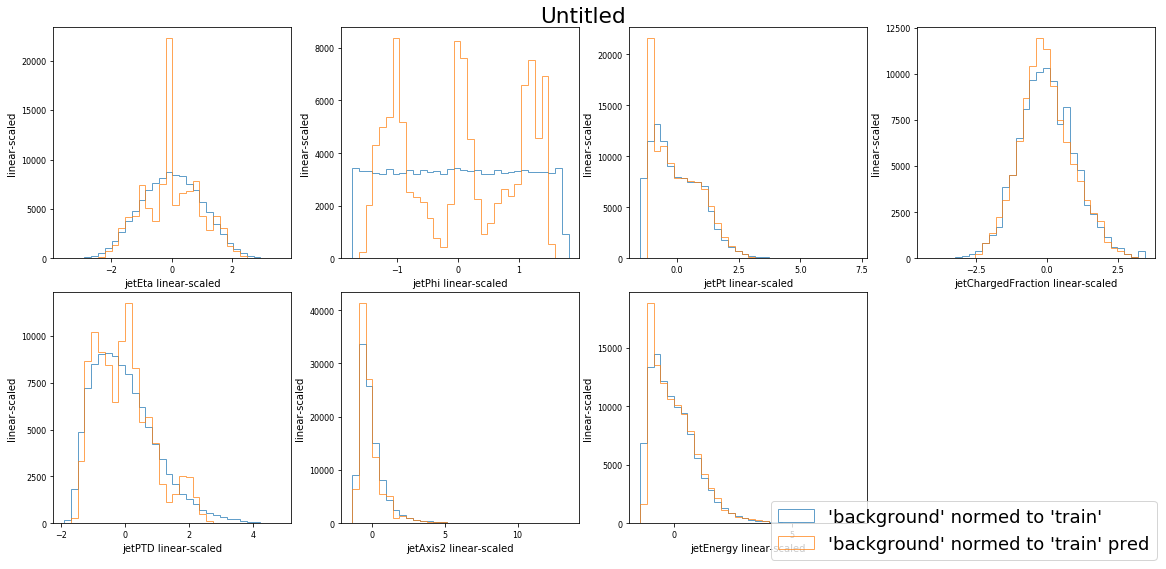

data_table :: plotting distrubution(s) for table(s) ["'signal' normed to 'train'", "'signal' normed to 'train' pred"]


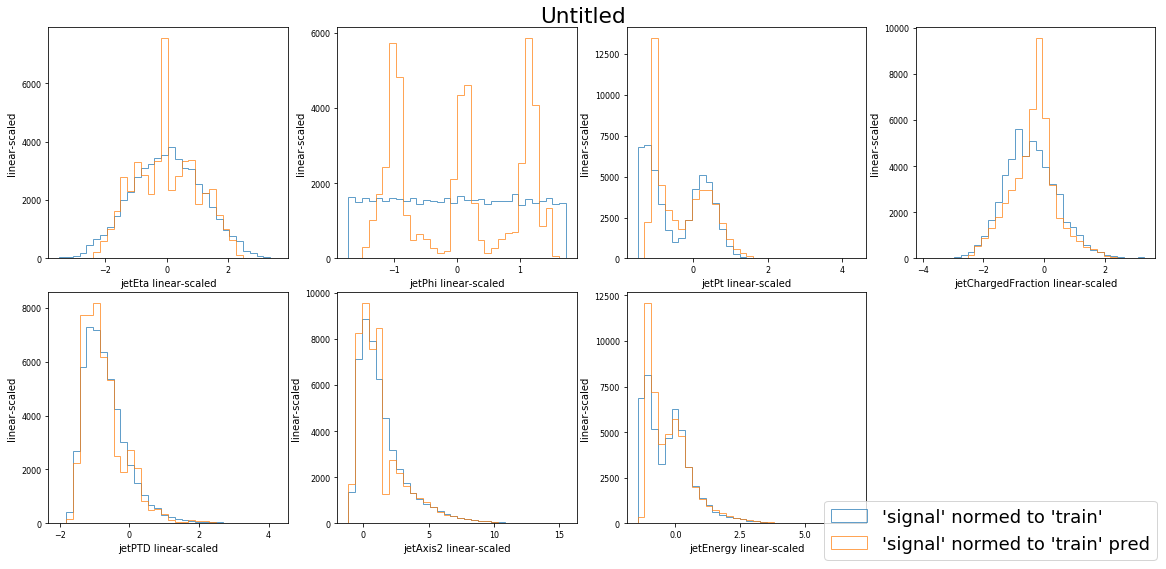

In [26]:
data_norm.plot(data_recon, normed=0)
signal_norm.plot(signal_recon, normed=0)

data_table :: plotting distrubution(s) for table(s) ["'background' normed to 'train' error", "'signal' normed to 'train' error"]


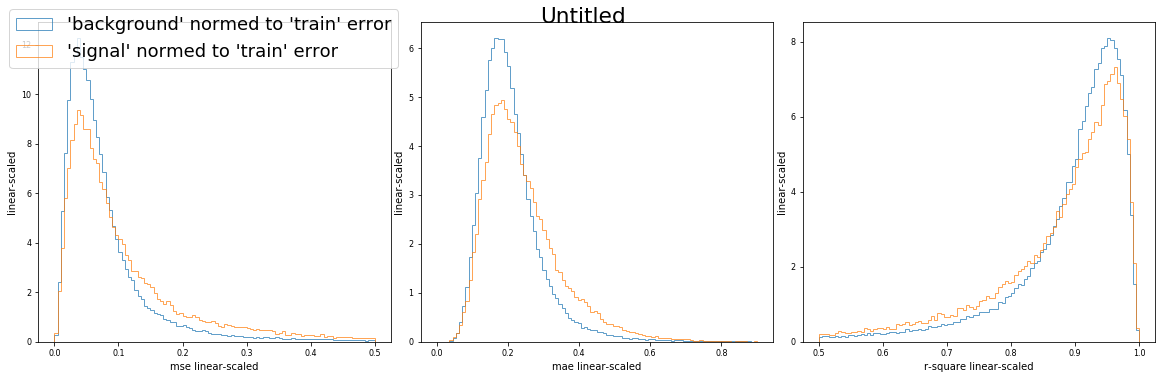

auc value: 0.59160684086


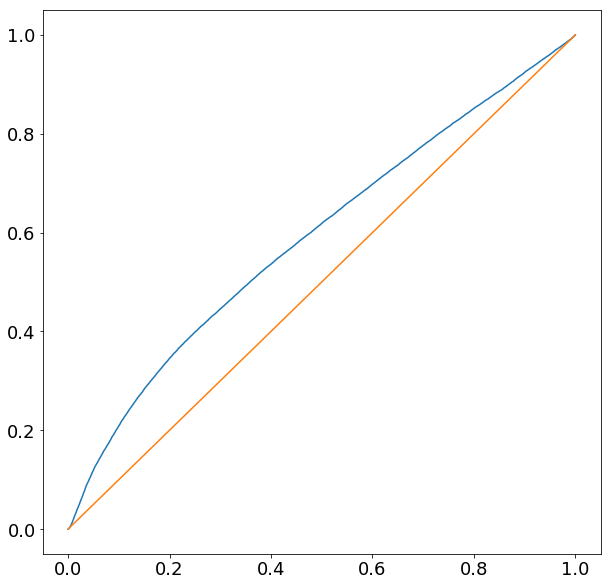

{'auc': 0.59160684085988879,
 'roc': (array([  0.00000000e+00,   9.66968361e-06,   9.66968361e-06, ...,
           9.99990330e-01,   1.00000000e+00,   1.00000000e+00]),
  array([  0.00000000e+00,   0.00000000e+00,   2.01954924e-05, ...,
           9.99979805e-01,   9.99979805e-01,   1.00000000e+00]),
  array([ 3.26978457,  2.26978457,  2.15954548, ...,  0.03176298,
          0.03170578,  0.02606612]))}

In [28]:
data_err.plot(signal_err, figloc="upper left", bins=100, rng=((0,.5), (0, 0.9), (0.5, 1.)), normed=1)

def roc_auc_plot(data_err, signal_err, metric='mae'):
    from sklearn.metrics import roc_curve, roc_auc_score
    pred = np.hstack([signal_err[metric].values, data_err[metric].values])
    true = np.hstack([np.ones(signal_err.shape[0]), np.zeros(data_err.shape[0])])

    roc = roc_curve(true, pred)
    auc = roc_auc_score(true, pred)
    print "auc value:", auc
    plt.figure(figsize=(10,10))
    # ax = fig.axes() 
    plt.plot(roc[0], roc[1])
    plt.plot((0,1), (0,1))
    plt.show()
    
    return {"roc": roc, "auc": auc}

roc_auc_plot(data_err, signal_err, 'mae')

In [39]:
# errors.plot(
#     errors_tagged,
#     figsize=(20,8), 
#     bins=40,
#     rng=((0,0.1), (0, 0.25), (.85,1)),
#     fontsize=20, cols=3, 
#     figloc="upper center",
#     normed=True,
#     yscale="linear",
#     histtype="step",
#     alpha=1
# )
# errors.plot(
#     errors_tagged,
#     figsize=(20,8), 
#     bins=40,
#     rng=((0,0.3), (0, 0.5), (.5,1)),
#     fontsize=20, cols=3, 
#     figloc="upper center",
#     normed=True,
#     yscale="log",
#     histtype="step",
#     alpha=1
# )
# errors.plot(
#     errors_tagged,
#     figsize=(20,8), 
#     bins=20,
#     rng=((.1,0.3), (.12, 0.5), (.5,.9)),
#     fontsize=20, cols=3, 
#     figloc="upper center",
#     normed=True,
#     yscale="linear",
#     histtype="step",
#     alpha=1
# )